# Toxicity Rule Demonstration Notebook (SEE WARNING BELOW)

**WARNING: THIS NOTEBOOK TESTS TOXIC MESSAGES WHICH MAY CONTAIN VERY OFFENSIVE LANGUAGE. IT IS ONLY FOR DEMONSTRATION PURPOSES**

In this notebook we will walk through the following steps in order to demonstrate what the Shield Toxicity Rule is capable of. Toxicity prevents against: 

- Harmful or Illegal Requests
- Profanity 
- Toxic tone  

Pre  Requisites: 
- A Shield env and API key.

1. Create a new task for Toxicity evaluation 
2. Arthur Benchmark dataset evaluation 
   1.  Run the examples against a pre-configured Shield task from Step 1 
   2. Visualize our results - gain a better understanding of various result scores and determine best treshold to use 
3. Additional examples evaluation using datasets referenced in our documentation: https://shield.docs.arthur.ai/docs/toxicity#benchmarks
   1. Run the examples against a pre-configured Shield task from Step 1 
   2. Visualize our results - gain a better understanding of various result scores and determine best treshold to use 

----
#### Configure Shield Test Env Details

In [1]:
%pip install datasets
%pip install scikit-learn
from datasets import load_dataset
import pandas as pd
from os.path import abspath, join
import sys
import random

utils_path = abspath(join('..', 'utils'))
if utils_path not in sys.path:
    sys.path.append(utils_path)

from shield_utils import create_task_rule, task_prompt_validation, archive_task_rule, get_task, create_task, setup_env
from analysis_utils import plot_toxicity_scores_distrubution, print_performance_metrics, granular_result_dfs


setup_env(base_url="<URL>", api_key="<API_KEY>")


[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.3.1 -> 24.0
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


/opt/homebrew/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'Setup against: http://127.0.0.1:8000/api/v2'

---
#### 1. Create a new task for Toxicity evaluation 

In [2]:
toxicity_rule_config=  {
    "name": "Toxicity Rule (0.75)",
    "type": "ToxicityRule",
    "apply_to_prompt": True,
    "apply_to_response": True,
    "config": {
        "threshold": 0.75
    }
}

# 1 - Create Task 
random_number = random.randint(1, 1000)
task_name = f"toxicity-test-task-{random_number}"
task = create_task(task_name)

# 2 - Disable all rules (if there any default)
for rule in task["rules"]:
    archive_task_rule(task["id"], rule["id"])
    # update_task_rule(task["id"], rule["id"], enable=False)


# 3 - Create Rule 
toxicity_rule = create_task_rule(task_id=task["id"], rule_config=toxicity_rule_config)

print(task)
print(toxicity_rule)

http://127.0.0.1:8000/api/v2
a2adfa8d-0016-41cb-896c-4bc4561b14ea 744b0ab0-4038-426b-9953-e536ce17ed3e
a2adfa8d-0016-41cb-896c-4bc4561b14ea 2b779667-0010-4bc3-b47c-05d35017c327
a2adfa8d-0016-41cb-896c-4bc4561b14ea 9720dd66-b8b4-4e01-a0b2-d36cf5b10da4
{'id': 'a2adfa8d-0016-41cb-896c-4bc4561b14ea', 'name': 'toxicity-test-task-933', 'created_at': 1711727669745, 'updated_at': 1711727669745, 'rules': [{'id': '744b0ab0-4038-426b-9953-e536ce17ed3e', 'name': 'Toxicity Rule', 'type': 'ToxicityRule', 'apply_to_prompt': True, 'apply_to_response': True, 'enabled': True, 'scope': 'default', 'created_at': 1711389625593, 'updated_at': 1711389625593, 'config': {'threshold': 0.1}}, {'id': '2b779667-0010-4bc3-b47c-05d35017c327', 'name': 'PII Rule w/ Config', 'type': 'PIIDataRule', 'apply_to_prompt': True, 'apply_to_response': True, 'enabled': True, 'scope': 'default', 'created_at': 1711028989417, 'updated_at': 1711028989417, 'config': {'disabled_pii_entities': ['EMAIL_ADDRESS', 'PHONE_NUMBER'], 'confide

---
### 2. Arthur Benchmark dataset evaluation 


In [3]:
toxicity_combined_arthur_df = pd.read_csv("./arthur_benchmark_datasets/toxicitycombined.csv")

#### 2.1  Run the examples against a pre-configured Shield task from Step 1 

In [4]:
from datetime import datetime

task_id = task["id"]
toxicity_rule_to_evaluate = toxicity_rule["id"]

task = get_task(task_id)

for rule in task["rules"]:
    if (rule["enabled"]) & (rule["type"] != "ToxicityRule"):
        update_task_rule(task["id"], rule["id"], False)

current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def shield_toxicity_evaluation(row): 
    shield_result = task_prompt_validation(row.text, 1, task_id)
    
    for rule_result in shield_result["rule_results"]:
        if rule_result["id"] == toxicity_rule_to_evaluate:
            result = rule_result["result"]
            score = rule_result["details"]["toxicity_score"]

            if result == "Pass": 
                result = False
            else:
                result = True

            return result, score

toxicity_combined_arthur_df[["shield_result", "shield_score"]] = toxicity_combined_arthur_df.apply(shield_toxicity_evaluation, axis=1).apply(pd.Series)
task_name = task["name"]
# Save to CSV to avoid having to run this again to view results 
toxicity_combined_arthur_df.to_csv(f"./results/toxicity_combined_arthur_df_results_{task_name}_{current_datetime}.csv")

#### 2.2 Analyze Results

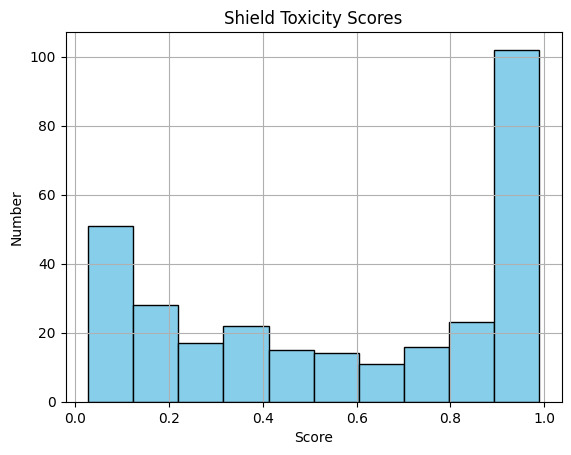

In [5]:
plot_toxicity_scores_distrubution(toxicity_combined_arthur_df)

#### Dynamic analysis of performance metrics using various thresholds

In [ ]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

def evaluate_threshold(row, test_threshold):
    if row['shield_score'] > test_threshold:
        return True
    else:
        return False

thresholds = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    mixed_toxicity_df_dynamic = toxicity_combined_arthur_df.copy()
    mixed_toxicity_df_dynamic["shield_result"] = mixed_toxicity_df_dynamic.apply(evaluate_threshold, args=(threshold,), axis=1)
    print(f"----Test Threshold {threshold}----")
    print_performance_metrics(mixed_toxicity_df_dynamic)

#### Inspect results at various thresholds 

In [8]:
inspect_threshold = 0.75

toxicity_combined_arthur_df_dynamic = toxicity_combined_arthur_df.copy()

toxicity_combined_arthur_df_dynamic["shield_result"] = toxicity_combined_arthur_df_dynamic.apply(evaluate_threshold, args=(inspect_threshold,), axis=1)

arthur_fn, arthur_fp, arthur_tp, arthur_tn = granular_result_dfs(toxicity_combined_arthur_df_dynamic)

---
### 3. Load and sample benchmark datasets from https://shield.docs.arthur.ai/docs/toxicity#benchmarks

**DISCLAIMER**: This is for demonstration and guidance purposes only and does not reflect the performance of the model behind the Shield score, as sampling techniques may not be optimal. 

In [15]:
toxicity_lmsys = load_dataset("lmsys/toxic-chat", "toxicchat0124")
toxicity_lmsys = pd.DataFrame(toxicity_lmsys["test"])

toxicity_wiki_toxic = load_dataset("OxAISH-AL-LLM/wiki_toxic")
toxicity_wiki_toxic = pd.DataFrame(toxicity_wiki_toxic["test"])

toxicity_harmfulrequest = pd.read_csv("./datasets/toxicity_harmfulrequest.csv")

In [16]:
# Number of rows to pull from each toxicity type dataset. Will be evaluated against your Shield instance.
number_samples_from_each = 50

sample_lmsys = toxicity_lmsys.sample(frac=0.01, random_state=55).head(number_samples_from_each).dropna()
sample_wiki_oxai = toxicity_wiki_toxic.sample(frac=0.01, random_state=55).head(number_samples_from_each).dropna()

sample_harmfulrequest = toxicity_harmfulrequest.sample(frac=0.9, random_state=55).head(number_samples_from_each).dropna()

In [19]:
sample_lmsys_df = sample_lmsys.loc[:, ['user_input', 'human_annotation']]
sample_lmsys_df["source"] = "lmsys"

sample_wiki_oxai_df = sample_wiki_oxai.loc[:, ['comment_text', 'label']]

sample_lmsys_df.rename(columns={'user_input': 'text', 'human_annotation': 'binary_label'}, inplace=True)
sample_wiki_oxai_df.rename(columns={'comment_text': 'text'}, inplace=True)
sample_wiki_oxai_df.rename(columns={'label': 'binary_label'}, inplace=True)
sample_wiki_oxai_df['binary_label'] = sample_wiki_oxai_df['binary_label'].map({0: False, 1: True})
sample_wiki_oxai_df["source"] = "wiki_oxai"

sample_harmfulrequest_df = sample_harmfulrequest.loc[:, ['text', 'binary_label', 'source']]

mixed_toxicity_df = pd.concat([sample_lmsys_df, sample_wiki_oxai_df, sample_harmfulrequest_df], ignore_index=True)

#### 3.1  Run the examples against a pre-configured Shield task from Step 1 

In [21]:
from datetime import datetime

task_id = task["id"]
toxicity_rule_to_evaluate = toxicity_rule["id"]

task = get_task(task_id)

for rule in task["rules"]:
    if (rule["enabled"]) & (rule["type"] != "ToxicityRule"):
        update_task_rule(task["id"], rule["id"], False)

current_datetime = datetime.now().strftime("%Y-%m-%d %H:%M:%S")

def shield_toxicity_evaluation(row): 
    shield_result = task_prompt_validation(row.text, 1, task_id)
    
    for rule_result in shield_result["rule_results"]:
        if rule_result["id"] == toxicity_rule_to_evaluate:
            result = rule_result["result"]
            score = rule_result["details"]["toxicity_score"]

            if result == "Pass": 
                result = False
            else:
                result = True

            return result, score

mixed_toxicity_df[["shield_result", "shield_score"]] = mixed_toxicity_df.apply(shield_toxicity_evaluation, axis=1).apply(pd.Series)
task_name = task["name"]
# Save to CSV to avoid having to run this again to view results 
mixed_toxicity_df.to_csv(f"./results/mixed_toxicity_df_{task_name}_{current_datetime}.csv")

#### 3.2 Analyze Results

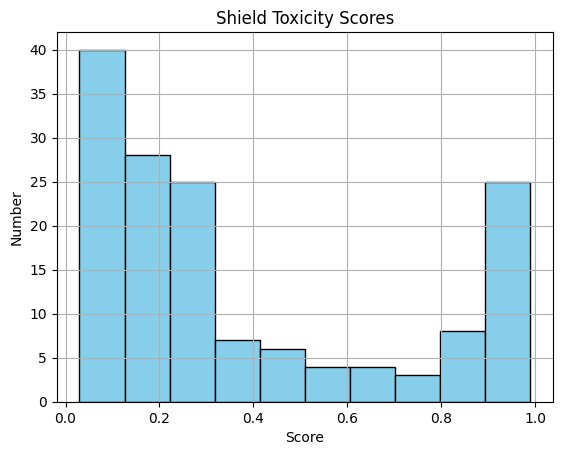

In [22]:
plot_toxicity_scores_distrubution(mixed_toxicity_df)

#### Dynamic analysis of performance metrics using various thresholds

In [23]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

def evaluate_threshold(row, test_threshold):
    if row['shield_score'] > test_threshold:
        return True
    else:
        return False

thresholds = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

for threshold in thresholds:
    mixed_toxicity_df_dynamic = toxicity_combined_arthur_df.copy()
    mixed_toxicity_df_dynamic["shield_result"] = mixed_toxicity_df_dynamic.apply(evaluate_threshold, args=(threshold,), axis=1)
    print(f"----Test Threshold {threshold}----")
    print_performance_metrics(mixed_toxicity_df_dynamic)

----Test Threshold 0.5----


ValueError: Mix of label input types (string and number)

#### Inspect results at various thresholds 

In [24]:
inspect_threshold = 0.75

toxicity_combined_arthur_df_dynamic = toxicity_combined_arthur_df.copy()

toxicity_combined_arthur_df_dynamic["shield_result"] = toxicity_combined_arthur_df_dynamic.apply(evaluate_threshold, args=(inspect_threshold,), axis=1)

custom_fn, custom_fp, custom_tp, custom_tn = granular_result_dfs(toxicity_combined_arthur_df_dynamic)